# Train Test Transformer based log outlier detection framework


*   Only suitable for log data that have logical relationship between neighbor logs
    - suitable for : HDFS; Hadoop; Openstack
    - not suitable for: BGL; Thunderbird (no obvious relationship)  


*   Same network architecture, but different embedding size for different log system. Different network objects are separately trained for different log system










# Preparing


*   fix bug of pytorch transformer framework
*   Connect to Gdrive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/openstack/functional.py /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py
#after first copy, restart the notebook


try:
    from pytorch_lightning.core.lightning import LightningModule
except ModuleNotFoundError:
    !pip install pytorch-lightning
    from pytorch_lightning.core.lightning import LightningModule

Mounted at /content/drive
     |████████████████████████████████| 915 kB 9.1 MB/s 
     |████████████████████████████████| 5.6 MB 27.6 MB/s 
     |████████████████████████████████| 829 kB 76.0 MB/s 
     |████████████████████████████████| 118 kB 69.0 MB/s 
     |████████████████████████████████| 272 kB 81.4 MB/s 
     |████████████████████████████████| 636 kB 77.1 MB/s 
     |████████████████████████████████| 1.3 MB 62.6 MB/s 
     |████████████████████████████████| 142 kB 76.0 MB/s 
     |████████████████████████████████| 294 kB 76.3 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=9aafb0231cea891d9c281639cd1651e4bc2ff4b53dd5856e284894511ffa81e1
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.

In [ ]:
# from torch.nn import Transformer
# float 16
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import LightningDataModule
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Optional
from torch.optim import Adam
import sklearn

class LogOutlier(LightningModule):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.2, padding_value = 512, target_value = 0):
        super().__init__()
        self.ninp = ninp
        self.padding_value = padding_value
        self.target_value = target_value
        # token embedding
        self.encoder = Embeddings(ninp, ntoken)
        # positional encoding
        self.pos_encoder = PositionalEncoding(ninp, dropout)

        # transformer encoder
        encoder_layers = TransformerEncoderLayerAttention(ninp, nhead, nhid, dropout)  # encoder_layer
        self.transformer_encoder = TransformerEncoderAttention(encoder_layers, nlayers)



        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1  # original 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, key_padding_mask, att_mask=None, require_attention=False, result_mask=None):
        # att_mask : for every sequence in batch is the same
        src = src.t()
        # pos encoder suppose input begin with sequence length
        src = self.encoder(src)

        src = self.pos_encoder(src)
        # attention! transformer need different input structure, first place is not batch size

        output, attention_list = self.transformer_encoder(src, src_key_padding_mask=key_padding_mask, mask=att_mask)

        src = None

        # change back to normal shape
        # att_mask  size(batch_size, sequence length mask)
        output = output.permute(1, 0, 2)[result_mask]

        output = self.decoder(output)

        if require_attention:
            return output, attention_list
        else:
            return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        src_key_padding_mask = (x == self.padding_value)
        # mask still on same device as x
        output_mask = (x == self.target_value)
        logits = self(x, key_padding_mask = src_key_padding_mask, result_mask =output_mask )
        loss_function = nn.CrossEntropyLoss()
        loss = loss_function(logits, y)
        self.log('my_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)


class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        # d_model = 0.25*vocab
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        self.lut.weight.data.uniform_(-0.1, 0.1)

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)


class PositionalEncoding(nn.Module):
    # input must be seq length
    def __init__(self, d_model, dropout=0.1, max_len=40):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerEncoderLayerAttention(TransformerEncoderLayer):
    def forward(self, src: Tensor, src_mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None) :
            r"""Pass the input through the encoder layer.

            Args:
                src: the sequence to the encoder layer (required).
                src_mask: the mask for the src sequence (optional).
                src_key_padding_mask: the mask for the src keys per batch (optional).

            Shape:
                see the docs in Transformer class.
            """
            src2,attention_weight = self.self_attn(src, src, src, attn_mask=src_mask,
                                key_padding_mask=src_key_padding_mask)
            src = src + self.dropout1(src2)
            src = self.norm1(src)
            src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
            src = src + self.dropout2(src2)
            src = self.norm2(src)
            return src, attention_weight

class TransformerEncoderAttention(TransformerEncoder):
    def forward(self, src: Tensor, mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None):
            r"""Pass the input through the encoder layers in turn.

            Args:
                src: the sequence to the encoder (required).
                mask: the mask for the src sequence (optional).
                src_key_padding_mask: the mask for the src keys per batch (optional).

            Shape:
                see the docs in Transformer class.
            """
            output = src
            attention_list = []

            for mod in self.layers:
                output,attention = mod(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)
                attention_list.append(attention.to(torch.device('cpu')))
                attention = None
            if self.norm is not None:
                output = self.norm(output)

            return output,attention_list

# Define Network

# Define Dataset Class

In [ ]:
import json
from torch.utils.data import Dataset, DataLoader
class sequence_generator(Dataset):
    def __init__(self,target_mask = 0, padding_number = 100, device = torch.device('cpu'), start_token = 62, end_token = 63, need_start_end = False):
        if torch.cuda.is_available():
            device = torch.device('cuda')
        self.tokens = set()
        self.sequence = {}
        self.max_length = 0# key: instance_id value: template id sequences
        self.target_mask = target_mask
        self.padding_number = padding_number
        
        self.seq_data = []
        self.device = device

        self.start_token = start_token
        self.end_token = end_token
        self.need_start_end = need_start_end

    
    def single_add(self,instance_id,template_id):
        self.tokens.update([template_id])
        if instance_id not in self.sequence.keys():
            self.sequence[instance_id] = []
        self.sequence[instance_id].append(template_id)
        #update max_length
        self.max_length = max(self.max_length,len(self.sequence[instance_id]))
    
    def list_add(self,instance_id,template_id):
        self.tokens.update(template_id)
        for i in range(len(instance_id)):
            if instance_id[i] not in self.sequence.keys():
                self.sequence[instance_id[i]] = []
            
            self.sequence[instance_id[i]].append(template_id[i])
            
            self.max_length = max(self.max_length,len(self.sequence[instance_id[i]]))
        # add start end
        if self.need_start_end:
            self.max_length += 2
            for key in self.sequence.keys():
                self.sequence[key] = [self.start_token] + self.sequence[key] + [self.end_token]               #add start and end

        self.update_Dataset()
            
    def update_Dataset(self,seqs = None ):
        if seqs == None:
            seqs = self.sequence.values()
        self.seq_data = []
        for seq in seqs:
            seq = [int(x) for x in seq]
            for i in range(len(seq)):
                tmp_seq = seq.copy()
                tmp_target = tmp_seq[i]
                tmp_seq[i] = self.target_mask

                self.seq_data.append((tmp_seq, tmp_target))
            #still a list
    
    def remove_duplicate(self):
        tmp = [json.dumps(x) for x in self.seq_data]
        tmp = set(tmp)
        self.seq_data = [eval(x) for x in tmp]
            
    def padding(self,seq):
        return seq+[self.padding_number]*(self.max_length-len(seq))
    
    #Dataset special methods
    
    def __len__(self):
        return len(self.seq_data)
    
    def __getitem__(self,idx):
        seq = self.seq_data[idx][0]
        seq = self.padding(seq)
        # save memory
        seq = torch.tensor(seq,dtype = torch.long, device=self.device)
        target = torch.tensor(self.seq_data[idx][1],dtype = torch.long, device = self.device)
        return seq, target

# Define Train Function

# Define Outlier score calculation function

*   input is list of template id; 

*   max_length not necessarily to be equal with train; 
*   padding and target but be same to train data





In [ ]:
def outlier_detection_single(seq,model,max_length,padding_number,target_mask,top = 10,inspect = False,max_size = 256):
    #prepare data
    seq_matrix = []
    target = []
    seq = [int(x) for x in seq]
    for i in range(len(seq)):
        tmp_seq = seq.copy()
        tmp_target = tmp_seq[i]
        tmp_seq[i] = target_mask
        seq_matrix.append(tmp_seq)
        target.append(tmp_target)
    
    #predict
    all_predict = []
    device = next(model.parameters()).device
    while len(seq_matrix)>0:
            X = torch.tensor(seq_matrix[:max_size],device = device)
            seq_matrix = seq_matrix[max_size:]
            #predict
            with torch.no_grad():
                model.eval()
                key_padding_mask = (X == padding_number)
                output_mask = (X==target_mask)
                output = model(X, key_padding_mask = key_padding_mask, result_mask =output_mask )
                predict = torch.topk(output,top,dim = 1).indices
                all_predict.extend(predict.tolist())
    
    #outlier score all_predict target
    return all_predict, target

In [ ]:
def outlier_score_calculation(all_predict, target ,top=1,relative = False, false_position = False):
    score = 0
    if false_position:
        p = []
    for i in range(len(target)):
        if target[i] not in all_predict[i][:top+1]:
            score+=1
            if false_position:
                p.append(i)
    torch.cuda.empty_cache()
    if relative:
        return score/len(target)
    else:
        if false_position:
            return score,p
        else:
            return score

**Openstack**

In [ ]:
import pandas as pd
openstack1 = pd.read_csv('/content/drive/MyDrive/openstack/openstack1.csv')
openstack2 = pd.read_csv('/content/drive/MyDrive/openstack/openstack2.csv')
abnormal = pd.read_csv('/content/drive/MyDrive/openstack/abnormal.csv')

# train val split
import random
random.seed(66)
uni_id = list(openstack1.Label.unique())

train_set = openstack1[openstack1.Label.isin(uni_id)].reset_index(drop=True)
#train_id = random.sample(uni_id,round(len(uni_id)*0.8))
#train_set = openstack1[openstack1.Label.isin(train_id)].reset_index(drop=True)
#test_set = openstack1[~openstack1.Label.isin(train_id)].reset_index(drop=True)

In [ ]:
openstack1.iloc[30:40]

,Logrecord,Date,Time,Pid,Level,Component,ADDR,Content,Label,Content_after_re,Template_id,Template_string
30,nova-compute.log.1.2017-05-16_13:55:31,2017-05-16,00:00:44.697,2931,INFO,nova.compute.manager,req-3ea4052c-895d-4b64-9e2d-04d64c4d94ab - - -...,[instance: 96abccce-8d1f-4e07-b6d1-4b2ab87e23b...,96abccce-8d1f-4e07-b6d1-4b2ab87e23b4,<*> During sync_power_state the instance has a...,2,<*> During sync power state the instance has a...
31,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:00:51.633,25743,INFO,nova.api.openstack.compute.server_external_events,req-3e22b75e-1c4f-4579-8a73-7ede40d3f955 f7b8d...,Creating event network-vif-plugged:a208479c-c0...,96abccce-8d1f-4e07-b6d1-4b2ab87e23b4,Creating event network-vif-plugged:a208479c-c0...,3,Creating event <*> for instance <*>
32,nova-compute.log.1.2017-05-16_13:55:31,2017-05-16,00:00:51.650,2931,INFO,nova.compute.manager,req-3ea4052c-895d-4b64-9e2d-04d64c4d94ab - - -...,[instance: 96abccce-8d1f-4e07-b6d1-4b2ab87e23b...,96abccce-8d1f-4e07-b6d1-4b2ab87e23b4,<*> VM Resumed (Lifecycle Event),1,<*> VM <*> (Lifecycle Event)
33,nova-compute.log.1.2017-05-16_13:55:31,2017-05-16,00:00:51.658,2931,INFO,nova.virt.libvirt.driver,-,[instance: 96abccce-8d1f-4e07-b6d1-4b2ab87e23b...,96abccce-8d1f-4e07-b6d1-4b2ab87e23b4,<*> Instance spawned successfully.,4,<*> Instance <*> successfully.
34,nova-compute.log.1.2017-05-16_13:55:31,2017-05-16,00:00:51.659,2931,INFO,nova.compute.manager,req-6a763803-4838-49c7-814e-eaefbaddee9d 113d3...,[instance: 96abccce-8d1f-4e07-b6d1-4b2ab87e23b...,96abccce-8d1f-4e07-b6d1-4b2ab87e23b4,<*> Took 19.96 seconds to spawn the instance o...,5,<*> Took <*> seconds to <*> the instance on th...
35,nova-compute.log.1.2017-05-16_13:55:31,2017-05-16,00:00:51.770,2931,INFO,nova.compute.manager,req-3ea4052c-895d-4b64-9e2d-04d64c4d94ab - - -...,[instance: 96abccce-8d1f-4e07-b6d1-4b2ab87e23b...,96abccce-8d1f-4e07-b6d1-4b2ab87e23b4,<*> During sync_power_state the instance has a...,2,<*> During sync power state the instance has a...
36,nova-compute.log.1.2017-05-16_13:55:31,2017-05-16,00:00:51.771,2931,INFO,nova.compute.manager,req-3ea4052c-895d-4b64-9e2d-04d64c4d94ab - - -...,[instance: 96abccce-8d1f-4e07-b6d1-4b2ab87e23b...,96abccce-8d1f-4e07-b6d1-4b2ab87e23b4,<*> VM Resumed (Lifecycle Event),1,<*> VM <*> (Lifecycle Event)
37,nova-compute.log.1.2017-05-16_13:55:31,2017-05-16,00:00:51.794,2931,INFO,nova.compute.manager,req-6a763803-4838-49c7-814e-eaefbaddee9d 113d3...,[instance: 96abccce-8d1f-4e07-b6d1-4b2ab87e23b...,96abccce-8d1f-4e07-b6d1-4b2ab87e23b4,<*> Took 20.71 seconds to build instance.,6,<*> Took <*> seconds to build instance.
38,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:00:59.410,25746,INFO,nova.osapi_compute.wsgi.server,req-d473bea3-588a-441a-8b2a-a137806f8786 113d3...,"10.11.10.1 ""DELETE /v2/54fadb412c4e40cdbaed933...",96abccce-8d1f-4e07-b6d1-4b2ab87e23b4,"10.11.10.1 ""DELETE /v2/54fadb412c4e40cdbaed933...",7,"10.11.10.1 ""DELETE <*> HTTP/1.1"" status: 204 l..."
39,nova-compute.log.1.2017-05-16_13:55:31,2017-05-16,00:00:59.446,2931,INFO,nova.compute.manager,req-d473bea3-588a-441a-8b2a-a137806f8786 113d3...,[instance: 96abccce-8d1f-4e07-b6d1-4b2ab87e23b...,96abccce-8d1f-4e07-b6d1-4b2ab87e23b4,<*> Terminating instance,8,<*> Terminating instance


In [ ]:
openstack1[openstack1.Label == openstack1.Label.unique()[66]]['Content'].to_list()
# the workflow of two log isntance is the same, also can't see obvious parameter outlier

['[instance: 112e18db-92ec-43f0-9a5e-8f58b868d02b] Attempting claim: memory 2048 MB, disk 20 GB, vcpus 1 CPU',
 '[instance: 112e18db-92ec-43f0-9a5e-8f58b868d02b] Total memory: 64172 MB, used: 512.00 MB',
 '[instance: 112e18db-92ec-43f0-9a5e-8f58b868d02b] memory limit: 96258.00 MB, free: 95746.00 MB',
 '[instance: 112e18db-92ec-43f0-9a5e-8f58b868d02b] Total disk: 15 GB, used: 0.00 GB',
 '[instance: 112e18db-92ec-43f0-9a5e-8f58b868d02b] disk limit not specified, defaulting to unlimited',
 '[instance: 112e18db-92ec-43f0-9a5e-8f58b868d02b] Total vcpu: 16 VCPU, used: 0.00 VCPU',
 '[instance: 112e18db-92ec-43f0-9a5e-8f58b868d02b] vcpu limit not specified, defaulting to unlimited',
 '[instance: 112e18db-92ec-43f0-9a5e-8f58b868d02b] Claim successful',
 '10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/112e18db-92ec-43f0-9a5e-8f58b868d02b HTTP/1.1" status: 200 len: 1708 time: 0.1968930',
 '[instance: 112e18db-92ec-43f0-9a5e-8f58b868d02b] Creating image',
 '[instance: 112e18db-92ec-4

In [ ]:
#abnormal[abnormal.Label == abnormal.Label.unique()[66]]['Content'].to_list()
abnormal[abnormal.Label == '544fd51c-4edc-4780-baae-ba1d80a0acfc']['Content'].to_list()
# the workflow of two log isntance is the same, also can't see obvious parameter outlier

['[instance: 544fd51c-4edc-4780-baae-ba1d80a0acfc] Attempting claim: memory 2048 MB, disk 20 GB, vcpus 1 CPU',
 '[instance: 544fd51c-4edc-4780-baae-ba1d80a0acfc] Total memory: 64172 MB, used: 512.00 MB',
 '[instance: 544fd51c-4edc-4780-baae-ba1d80a0acfc] memory limit: 96258.00 MB, free: 95746.00 MB',
 '[instance: 544fd51c-4edc-4780-baae-ba1d80a0acfc] Total disk: 15 GB, used: 0.00 GB',
 '[instance: 544fd51c-4edc-4780-baae-ba1d80a0acfc] disk limit not specified, defaulting to unlimited',
 '[instance: 544fd51c-4edc-4780-baae-ba1d80a0acfc] Total vcpu: 16 VCPU, used: 0.00 VCPU',
 '[instance: 544fd51c-4edc-4780-baae-ba1d80a0acfc] vcpu limit not specified, defaulting to unlimited',
 '[instance: 544fd51c-4edc-4780-baae-ba1d80a0acfc] Claim successful',
 '10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/544fd51c-4edc-4780-baae-ba1d80a0acfc HTTP/1.1" status: 200 len: 1708 time: 0.2008200',
 '[instance: 544fd51c-4edc-4780-baae-ba1d80a0acfc] Creating image',
 '[instance: 544fd51c-4edc-4

In [ ]:
train_sg = sequence_generator(0,40,start_token= 41, end_token= 42, need_start_end= True)
#test_sg = sequence_generator(0,40)


train_sg.list_add(train_set['Label'],train_set['Template_id'])
#test_sg.list_add(test_set['Label'],test_set['Template_id'])

train_sg.update_Dataset()
#test_sg.update_Dataset()

openstack2_sg = sequence_generator(0,40,start_token= 41, end_token= 42, need_start_end= True)
openstack2_sg.list_add(openstack2['Label'],openstack2['Template_id'])

abnormal_sg = sequence_generator(0,40,start_token= 41, end_token= 42, need_start_end= True)
abnormal_sg.list_add(abnormal['Label'],abnormal['Template_id'])

In [ ]:
model = LogOutlier(ntoken = 64, ninp = 16, nhead = 4, nhid = 16 , nlayers = 4, dropout=0.2, padding_value= 40, target_value= 0)
# 1 0.1

In [ ]:
train_dataloader = DataLoader(train_sg,256)
#val_dataloader = DataLoader(test_sg,2048)

In [ ]:
from pytorch_lightning import Trainer
trainer = Trainer(precision=16,gpus=1,max_epochs = 100)

trainer.fit(model, train_dataloader)
#trainer.fit(model,dataloader)

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                        | Params
--------------------------------------------------------------------
0 | encoder             | Embeddings                  | 1.0 K 
1 | pos_encoder         | PositionalEncoding          | 0     
2 | transformer_encoder | TransformerEncoderAttention | 6.8 K 
3 | decoder             | Linear                      | 1.1 K 
--------------------------------------------------------------------
8.9 K     Trainable params
0         Non-trainable params
8.9 K     Total params
0.036     Total estimated model params size (MB)


In [ ]:
# Test
abnormal_sg.max_length

31

In [ ]:
normal[0]

NameError: ignored

In [ ]:
# layer 5
normal = list(openstack2_sg.sequence.values())

abnormal = list(abnormal_sg.sequence.values())

test = normal+abnormal
ground_truth = [0]*len(normal)+[1]*len(abnormal)

# if label.txt is correct:
'''
outlier_ids = ['544fd51c-4edc-4780-baae-ba1d80a0acfc',
'ae651dff-c7ad-43d6-ac96-bbcd820ccca8',
'a445709b-6ad0-40ec-8860-bec60b6ca0c2',
'1643649d-2f42-4303-bfcd-7798baec19f9'] # maybe it is parameter outlier
'''
'''
test = []
keys = []
for i in openstack2_sg.sequence.keys():
        keys.append(i)
        test.append(openstack2_sg.sequence[i])
    #else:
        #ground_truth.append(0)
ground_truth = [0]*len(keys)
'''

from tqdm.notebook import tqdm
model.to(torch.device('cuda'))
hdfs_output = []
for i in tqdm(test):
    hdfs_output.append(outlier_detection_single(i,model,30,40,0,top=10)) #2 is best for hdfs



In [ ]:
def with_different_threshold(hdfs_output,threshold = 1,need_plot = False,false_position = True):    
    hdfs_predict = []
    pppppp = []
    for all_predict, target in tqdm(hdfs_output):
        if not false_position:
            hdfs_predict.append(outlier_score_calculation(all_predict, target ,top=threshold,relative=False,false_position=false_position))

        else:
            score,position_ = outlier_score_calculation(all_predict, target ,top=threshold,relative=False,false_position=false_position)
            hdfs_predict.append(score)
            pppppp.append(position_)

    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(ground_truth, hdfs_predict)
    if need_plot:
        import matplotlib.pyplot as plt
        import seaborn as sns
        plt.figure(figsize=(10,10))
        ax = sns.lineplot(x = recall, y= precision)
        ax.set(xlabel='recall', ylabel='precision')
        ax.set(ylim=(0,1))
        ax.set(xlim=(0,1))
        plt.show()


    f1 = 0
    p = 0
    r = 0
    for i in range(len(precision)):
        f1_ = 2 * precision[i] * recall[i]/(precision[i]+recall[i])
        if f1_>f1:
            f1 = f1_
            p = precision[i]
            r = recall[i]
    print(p,r,f1)
    return (threshold,precision,recall,thresholds,ground_truth,hdfs_predict,pppppp), f1

In [ ]:
k = (0,0)
for i in range(10):
    kk = with_different_threshold(hdfs_output=hdfs_output,threshold = i+1)
    if kk[1]>k[1]:
        k = kk
#print(k[0][0])


0.13086582947785855 1.0 0.23144360023378138



0.13086582947785855 1.0 0.23144360023378138



0.13086582947785855 1.0 0.23144360023378138



0.13086582947785855 1.0 0.23144360023378138



0.13086582947785855 1.0 0.23144360023378138



0.13086582947785855 1.0 0.23144360023378138



0.13086582947785855 1.0 0.23144360023378138



0.13086582947785855 1.0 0.23144360023378138



0.13086582947785855 1.0 0.23144360023378138



0.13086582947785855 1.0 0.23144360023378138


In [ ]:
#Path = '/content/drive/MyDrive/hdfs'+'loss=0.276'+'ntoken = 40, ninp = 16, nhead = 2, nhid = 16 , nlayers = 4, dropout=0.2, padding_value= 36, target_value= 0'+'.h5'
#torch.save(model.state_dict(), Path)

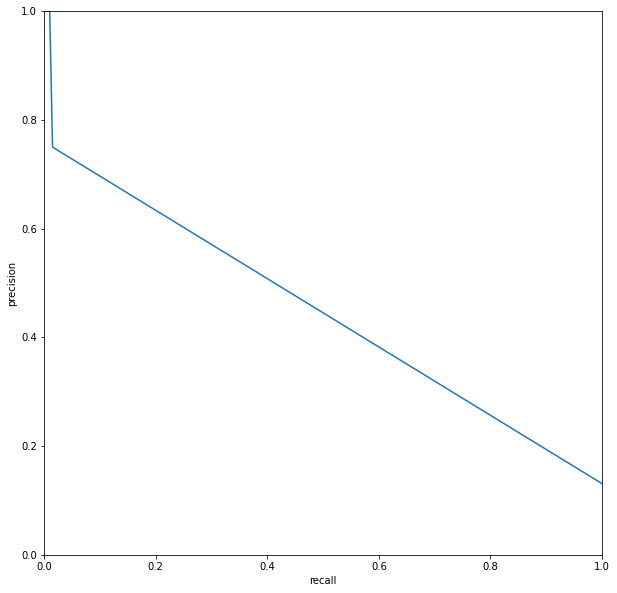

0.13086582947785855 1.0 0.23144360023378138


In [ ]:
kk = with_different_threshold(hdfs_output=hdfs_output,threshold = 10, need_plot= True,false_position=True)

In [ ]:
possible = []
place = []
for i in range(len(keys)):
    if kk[0][-2][i]>2:
        possible.append(keys[i])
        place.append(kk[0][-1][i])

NameError: ignored

In [ ]:
place

[[0, 1, 3], [11, 22, 23, 24], [22, 23, 24], [22, 23, 24]]

In [ ]:
possible

['0f079bdd-4117-4f6a-8b49-f3fb720b483c',
 '62468757-c12d-4d9f-a72a-c4bd74804f63',
 '8f461f4f-9e0e-422a-8266-be2671d16abe',
 'd9cc331c-7c5d-4507-89de-1d78c3b0bddc']

In [ ]:
openstack1[openstack1.Label == openstack1.Label.unique()[200]]['Content'].to_list()

['[instance: f8707b01-1147-4fcd-b103-128d7accb66c] Attempting claim: memory 2048 MB, disk 20 GB, vcpus 1 CPU',
 '[instance: f8707b01-1147-4fcd-b103-128d7accb66c] Total memory: 64172 MB, used: 512.00 MB',
 '[instance: f8707b01-1147-4fcd-b103-128d7accb66c] memory limit: 96258.00 MB, free: 95746.00 MB',
 '[instance: f8707b01-1147-4fcd-b103-128d7accb66c] Total disk: 15 GB, used: 0.00 GB',
 '[instance: f8707b01-1147-4fcd-b103-128d7accb66c] disk limit not specified, defaulting to unlimited',
 '[instance: f8707b01-1147-4fcd-b103-128d7accb66c] Total vcpu: 16 VCPU, used: 0.00 VCPU',
 '[instance: f8707b01-1147-4fcd-b103-128d7accb66c] vcpu limit not specified, defaulting to unlimited',
 '[instance: f8707b01-1147-4fcd-b103-128d7accb66c] Claim successful',
 '10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/f8707b01-1147-4fcd-b103-128d7accb66c HTTP/1.1" status: 200 len: 1708 time: 0.1900339',
 '[instance: f8707b01-1147-4fcd-b103-128d7accb66c] Creating image',
 '[instance: f8707b01-1147-4

In [ ]:
id = possible[2]
content = openstack2[openstack2.Label == id]['Content'].to_list()
content = ['start']+content+['end']
for i in range(len(content)):
    print(i,content[i])
[22, 23, 24]

0 start
1 [instance: 8f461f4f-9e0e-422a-8266-be2671d16abe] Attempting claim: memory 2048 MB, disk 20 GB, vcpus 1 CPU
2 [instance: 8f461f4f-9e0e-422a-8266-be2671d16abe] Total memory: 64172 MB, used: 512.00 MB
3 [instance: 8f461f4f-9e0e-422a-8266-be2671d16abe] memory limit: 96258.00 MB, free: 95746.00 MB
4 [instance: 8f461f4f-9e0e-422a-8266-be2671d16abe] Total disk: 15 GB, used: 0.00 GB
5 [instance: 8f461f4f-9e0e-422a-8266-be2671d16abe] disk limit not specified, defaulting to unlimited
6 [instance: 8f461f4f-9e0e-422a-8266-be2671d16abe] Total vcpu: 16 VCPU, used: 0.00 VCPU
7 [instance: 8f461f4f-9e0e-422a-8266-be2671d16abe] vcpu limit not specified, defaulting to unlimited
8 [instance: 8f461f4f-9e0e-422a-8266-be2671d16abe] Claim successful
9 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/8f461f4f-9e0e-422a-8266-be2671d16abe HTTP/1.1" status: 200 len: 1708 time: 0.1960180
10 [instance: 8f461f4f-9e0e-422a-8266-be2671d16abe] Creating image
11 [instance: 8f461f4f-9e0e-422a-8266-b

In [ ]:
precision,recall = kk[0][1:3]

In [ ]:
import pandas as pd
pr_auc_data = pd.DataFrame({'precision': precision, 'recall': recall})
pr_auc_data = pr_auc_data.sort_values('recall',ascending= True)
pr_auc = sklearn.metrics.auc(pr_auc_data.recall, pr_auc_data.precision)
pr_auc

0.44827989077823843

In [ ]:
def return_percentage_threshold(prediction):
    pp = sorted(prediction)
    thr = []
    for i in range(5):
        thr.append(pp[-round(len(pp)*(i+1)/100)])
    return thr

def predict(score,thr):
    returns =[]
    for i in score:
        if i>=thr:
            returns.append(1)
        else:
            returns.append(0)
    return returns

thrs = return_percentage_threshold(kk[0][5])
thrs

[0, 0, 0, 0, 0]

In [ ]:
# top 1% report as outlier
final_pre = predict(kk[0][5],thrs[0])
sklearn.metrics.precision_recall_fscore_support(kk[0][4],final_pre)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.        , 0.13086583]),
 array([0., 1.]),
 array([0.       , 0.2314436]),
 array([1315,  198]))

In [ ]:
# top 2% report as outlier
final_pre = predict(kk[0][5],thrs[1])
sklearn.metrics.precision_recall_fscore_support(kk[0][4],final_pre)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.        , 0.13086583]),
 array([0., 1.]),
 array([0.       , 0.2314436]),
 array([1315,  198]))

In [ ]:
# top 2% report as outlier
final_pre = predict(kk[0][5],thrs[2])
sklearn.metrics.precision_recall_fscore_support(kk[0][4],final_pre)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.        , 0.13086583]),
 array([0., 1.]),
 array([0.       , 0.2314436]),
 array([1315,  198]))